In [4]:
from pathlib import Path
from tifffile import imread, imwrite
import numpy as np
import sys
sys.path.append("../")
from utils import *

In [5]:
DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SUPERVISED_PERF_FIG/TRAINING"
gt_path = DATA_PATH / "dataset_float32/labels/semantic"

folds = 1
stardist_path = Path("E:/Code/CELLSEG_BENCHMARK/SUPERVISED_PERF_FIG/TRAINING").resolve()
models_pred_path = [(stardist_path / f"fold{i+1}").resolve() for i in range(folds)] 
# models_pred_path = [(DATA_PATH / f"fold{i+1}").resolve() for i in range(folds)] 

In [6]:
gt_images = {}
# load images in gt_path
for img_path in gt_path.glob("*.tif"):
    img = imread(img_path)
    gt_images[img_path.stem[:2]] = img

In [7]:
# for each fold and model, the goal is to compute what is the best threshold for the model, based on Dice between the GT and the prediction
dices_df = pd.DataFrame(columns=["Image", "Threshold", "NMS", "Dice", "Fold"])
for model_pred_path in models_pred_path:
    print("Fold : ", model_pred_path.name)
    preds_path = model_pred_path / "stardist" 
    for i, img_path in enumerate(preds_path.glob("*.tif")):
        img_name = img_path.stem
        print(f"Image: {img_name[:2]}")
        img = imread(img_path)
        gt = gt_images[img_name[:2]]
        nms = float(img_path.stem.split("_nms_")[1].split("_prob_")[0])
        prob_thresh = float(img_path.stem.split("_prob_")[1])
        print("Threshold: ", prob_thresh)
        print("NMS: ", nms)
        # gt = np.where(gt > 0, 1, 0) 3 already semantic
        pred = np.where(img > 0, 1, 0)
        dice = dice_coeff(y_true=gt, y_pred=pred)
        dices_df.loc[len(dices_df.index)] = [img_name[:2], prob_thresh, nms, dice, model_pred_path.name]

Fold :  fold1
Image: c1
Threshold:  0.1
NMS:  0.1
Image: c1
Threshold:  0.2
NMS:  0.1
Image: c1
Threshold:  0.3
NMS:  0.1
Image: c1
Threshold:  0.4
NMS:  0.1
Image: c1
Threshold:  0.5
NMS:  0.1
Image: c1
Threshold:  0.6
NMS:  0.1
Image: c1
Threshold:  0.7
NMS:  0.1
Image: c1
Threshold:  0.8
NMS:  0.1
Image: c1
Threshold:  0.9
NMS:  0.1
Image: c1
Threshold:  0.1
NMS:  0.2
Image: c1
Threshold:  0.2
NMS:  0.2
Image: c1
Threshold:  0.3
NMS:  0.2
Image: c1
Threshold:  0.4
NMS:  0.2
Image: c1
Threshold:  0.5
NMS:  0.2
Image: c1
Threshold:  0.6
NMS:  0.2
Image: c1
Threshold:  0.7
NMS:  0.2
Image: c1
Threshold:  0.8
NMS:  0.2
Image: c1
Threshold:  0.9
NMS:  0.2
Image: c1
Threshold:  0.1
NMS:  0.3
Image: c1
Threshold:  0.2
NMS:  0.3
Image: c1
Threshold:  0.3
NMS:  0.3
Image: c1
Threshold:  0.4
NMS:  0.3
Image: c1
Threshold:  0.5
NMS:  0.3
Image: c1
Threshold:  0.6
NMS:  0.3
Image: c1
Threshold:  0.7
NMS:  0.3
Image: c1
Threshold:  0.8
NMS:  0.3
Image: c1
Threshold:  0.9
NMS:  0.3
Image: c1
Thre

In [8]:
dices_df.sort_values(by="Threshold", inplace=True)
dices_df

,Image,Threshold,NMS,Dice,Fold
0,c1,0.1,0.1,0.487222,fold1
144,c2,0.1,0.8,0.419264,fold1
261,c4,0.1,0.3,0.499175,fold1
369,c5,0.1,0.6,0.530517,fold1
333,c5,0.1,0.2,0.539662,fold1
...,...,...,...,...,...
35,c1,0.9,0.4,0.499019,fold1
89,c2,0.9,0.1,0.485799,fold1
314,c4,0.9,0.8,0.515211,fold1
377,c5,0.9,0.6,0.557422,fold1


In [9]:
dices_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])

C:\Users\Cyril\AppData\Local\Temp\ipykernel_9564\971282983.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dices_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])


367,Image,Threshold,NMS,Dice,Fold
Fold,,,,,
fold1,c5,0.8,0.5,0.560387,fold1


In [10]:
dices_df.groupby("Threshold").Dice.median().sort_values(ascending=False).head(5)

Threshold
0.8    0.501275
0.9    0.498347
0.7    0.495357
0.6    0.486706
0.5    0.483121
Name: Dice, dtype: float64

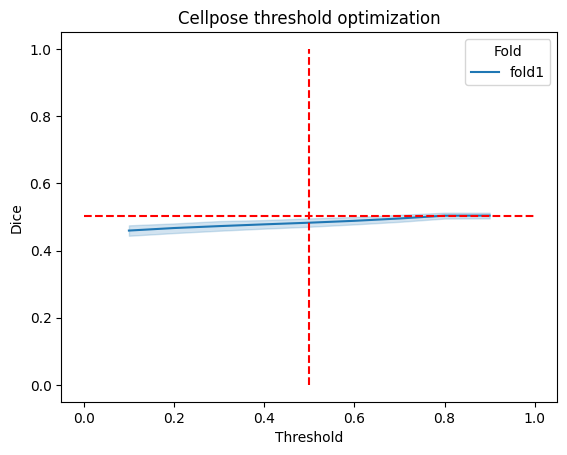

In [13]:
# plot for SegRes
sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.hlines(y=dices_df.groupby("Threshold").Dice.median().max(), xmin=0, xmax=1, color="red", linestyles="--")
plt.vlines(x=0.5, ymin=0, ymax=1,color="red", linestyles="--")
plt.title("Cellpose threshold optimization")
plt.show()

<Axes: xlabel='NMS', ylabel='Dice'>

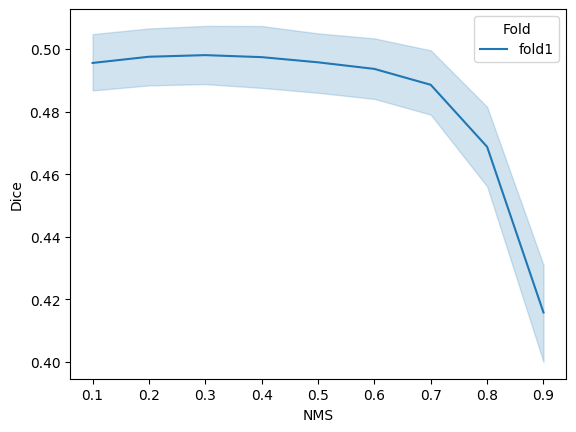

In [15]:
sns.lineplot(data=dices_df, x="NMS", y="Dice", hue="Fold")

In [16]:
# create a new column with joint NMS-threshold value, where NMS is multiplied by 10 and added to the threshold
dices_df["NMS_Threshold"] = dices_df["NMS"].apply(lambda x: x*10) + dices_df["Threshold"]

In [18]:
dices_df.groupby("NMS_Threshold").Dice.median().sort_values(ascending=False).head(5)

NMS_Threshold
3.8    0.502438
5.8    0.502312
6.8    0.502295
4.8    0.502286
2.8    0.501251
Name: Dice, dtype: float64

<Axes: xlabel='NMS_Threshold', ylabel='Dice'>

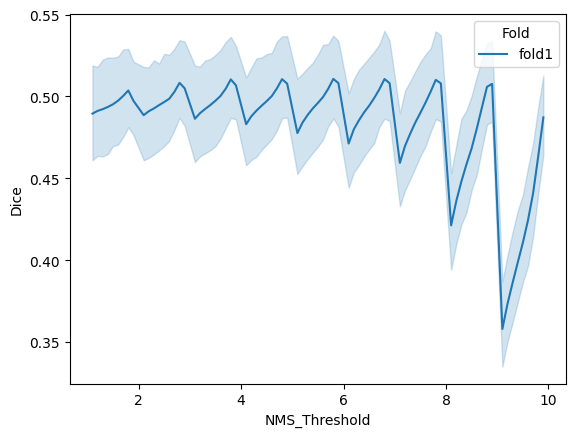

In [17]:
sns.lineplot(data=dices_df, x="NMS_Threshold", y="Dice", hue="Fold")